In [9]:
# =====================
# !!! LOAD TEMPLATE !!!
# =====================

# IMPORTS ---!
import gammalib
import ctools
import cscripts
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import seaborn as sns
import sys
from sys import argv

from module_analysis import *
from module_xml import *

workdir = '/home/ambra/Desktop/cluster-morgana/run0406_plots/run0406/' 
path = workdir + 'run0406_ID000126/'
datapath = path + 'data/'
simpath = path + 'sim/'
template = workdir + 'run0406_ID000126.fits'
template_ebl = workdir + 'run0406_ID000126_ebl.fits'
model = workdir + 'run0406_ID000126.xml'

hdul =  fits.open(template)
hdul.info()

rootname ='gilmore_test'
pathout = datapath

# 41 energybins [GeV] ---!
energy=np.array(hdul[1].data)
# 71 timebins [s] ---!
time=np.array(hdul[2].data)
# spectra no EBL ---!
spectra=np.array(hdul[3].data)

z=hdul[0].header['REDSHIFT']
print(z)

Nt=len(time)
Ne=len(energy)

primary = hdul[0].header
trueRA = primary['RA']
trueDEC = primary['DEC']

print(trueRA, trueDEC)

# TIME GRID ---!
t=[0.0 for x in range(Nt+1)]
for i in range(Nt-1):
    t[i+1]=time[i][0]+(time[i+1][0]-time[i][0])/2
# tmax bin ---!
t[Nt]=time[Nt-1][0]+(time[Nt-1][0]-t[Nt-1])

# ENERGY GRID ---!
en=[1.0 for x in range(Ne+1)]
for i in range(Ne-1):
    en[i+1]=energy[i][0]+(energy[i+1][0]-energy[i][0])/2
# emax bin ---!
en[Ne]=energy[Ne-1][0]+(energy[Ne-1][0]-en[Ne-1])

print('E', energy.shape, 't', time.shape, 'spectra', spectra.shape)

Filename: /home/ambra/Desktop/cluster-morgana/run0406_plots/run0406/run0406_ID000126.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  ENERGIES      1 BinTableHDU     13   41R x 1C   [E]   
  2  TIMES         1 BinTableHDU     13   71R x 1C   [E]   
  3  SPECTRA       1 BinTableHDU     92   71R x 41C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   
0.097
33.057 -51.841
E (41,) t (71,) spectra (71,)


In [2]:
# ========================
# !!! LOAD GILMORE EBL !!!
# ========================

pathebl = '/home/ambra/Desktop/cluster-morgana/'
fiducial = pathebl + 'gilmore_tau_fiducial.csv'

df = pd.read_csv(fiducial)
cols = list(df.columns)
df.dropna()

z01 = np.array(df['0.10'])
E = np.array(df[cols[0]]) # MeV
E = E/1e3

print('Energy (GeV)')

Energy (GeV)


/home/ambra/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


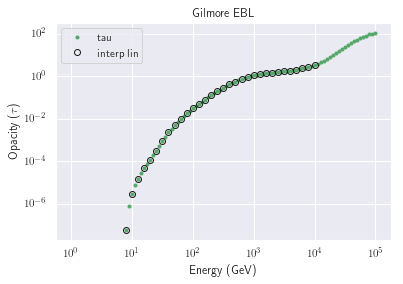

In [3]:
# =====================
# !!! INTERPOLATION !!!
# =====================

from scipy.interpolate import interp1d

y = np.zeros(shape=len(energy))+1
ylin = interp1d(E, z01)
#ycub = interp1d(E, z01, kind='cubic')
x = np.linspace(0, len(E), endpoint=True)

fig = plt.figure()
plt.rc('text', usetex=True)
sns.set()

ax = plt.subplot(111, xscale='log', yscale='log')
ax.plot(E, z01, '.', label='tau', c='g')
ax.plot(energy, ylin(energy), 'o', c='k', markeredgecolor='k', markerfacecolor='none', label='interp lin')
#ax.plot(energy, ycub(energy), '*', c='r', markeredgecolor='k', markerfacecolor='none', label='interp cub')
ax.set_ylabel('Opacity ($\\tau$)')
ax.set_xlabel('Energy (GeV)')
ax.set_title('Gilmore EBL')
ax.legend(loc='best')

fig.savefig('gilmore_tau_interpolation.png')
plt.show()

In [6]:
# ===========================
# !!! EBL GILMORE SPECTRA !!!
# ===========================

tau_gilmore = np.array(ylin(energy))
print('Gilmore tau')
print(ebl_gilmore.shape, spectra.shape, tau_gilmore.shape)

ebl_gilmore = np.empty_like(spectra)

for i in range(len(time)) :
    for j in range(len(energy)) :
        ebl_gilmore[j] = spectra[i][j] * np.exp(-tau_gilmore[j])

print('ebl spectra')
print(ebl_gilmore.shape)

Gilmore tau
(71,) (71,) (41,)
ebl spectra
(71,)


In [7]:
# ===========================
# !!! CREATE THE NEW FITS !!!
# ===========================

hdu = fits.BinTableHDU(name='EBL Gilmore', data=ebl_gilmore)

#print(hdu.header)
header = hdu.header
header.set('UNITS', 'ph/cm2/s/GeV', ' ')

hdu = fits.BinTableHDU(name='EBL Gilmore', data=ebl_gilmore, header=header)
print(hdu.header)

hdul.append(hdu)

os.system('rm ' + template_ebl)
hdul.writeto(template_ebl, overwrite=False)
hdul.close()


XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  328 / length of dimension 1                          NAXIS2  =                   71 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                   41 / number of table fields                         EXTNAME = 'EBL GILMORE'        / extension name                                 UNITS   = 'ph/cm2/s/GeV'       /                                                TTYPE1  = 'col0    '                                                            TFORM1  = 'D       '                                                            TTYPE2  = 'col1    '                    